In [110]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import time
from datetime import datetime
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
import pylab
from matplotlib import pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import sklearn.linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint



In [ ]:
'''
Follow directions here to create an API to access the data hosted on 
the drive: https://pythonhosted.org/PyDrive/quickstart.html

Once the client_secrets.json file is in ./Marin Workspace/ run the code 
below just once
'''
gauth = GoogleAuth()
gauth.LocalWebserverAuth()

In [ ]:
'''
Run the following code to download the data using the file's ID
'''
SP500_sectors_filled = '1S6lRlfRRVJT2pH_fLBgX9ZbWjroD-DSZ'
drive = GoogleDrive(gauth)
data = drive.CreateFile({'id': all_stocks_5yr})
data.GetContentFile('SP500_sectors_filled.csv')

In [3]:
sp_filled = pd.read_csv('SP500_sectors_filled.csv')

In [4]:
def remove_nulls(df):
    '''
    Takes in a dataframe and returns a mutated dataframe with rows of missing data dropped.
    '''
    
    df.dropna(inplace=True)
    
    return df

In [5]:
sp_filled.head()

,date,open,high,low,close,volume,Name,per_change,Sector
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,-0.021234,Industrials
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,-0.028878,Industrials
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,-0.012457,Industrials
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,0.025175,Industrials
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,-0.063588,Industrials


In [6]:
sp_filled = remove_nulls(sp_filled)

In [7]:
sp_filled.isnull().sum()

date          0
open          0
high          0
low           0
close         0
volume        0
Name          0
per_change    0
Sector        0
dtype: int64

In [8]:
sp_filled.Sector.unique()

array(['Industrials', 'Information Technology', 'Consumer Discretionary',
       'Health Care', 'Consumer Staples', 'Utilities', 'Financials',
       'Real Estate', 'Materials', 'Energy', 'Telecommunication Services'], dtype=object)

In [9]:
industrials_df = sp_filled[sp_filled['Sector'] == 'Industrials']
information_technology_df = sp_filled[sp_filled['Sector'] == 'Information Technology']
consumer_discretionary_df = sp_filled[sp_filled['Sector'] == 'Consumer Discretionary']
health_care_df = sp_filled[sp_filled['Sector'] == 'Health Care']
consumer_staples_df = sp_filled[sp_filled['Sector'] == 'Consumer Staples']
utilities_df = sp_filled[sp_filled['Sector'] == 'Utilities']
financials_df = sp_filled[sp_filled['Sector'] == 'Financials']
real_estate_df = sp_filled[sp_filled['Sector'] == 'Real Estate']
materials_df = sp_filled[sp_filled['Sector'] == 'Materials']
energy_df = sp_filled[sp_filled['Sector'] == 'Energy']
telecommunication_services_df = sp_filled[sp_filled['Sector'] == 'Telecommunication Services']

In [10]:
real_estate_df.head(5)

,date,open,high,low,close,volume,Name,per_change,Sector
25180,2013-02-08,27.40,28.665,27.2675,28.57,1801890,AIV,0.042701,Real Estate
25181,2013-02-11,28.57,29.010,28.5700,28.92,2555514,AIV,0.012251,Real Estate
25182,2013-02-12,28.87,29.160,28.7800,29.16,1558832,AIV,0.010045,Real Estate
25183,2013-02-13,29.03,29.110,28.7050,28.90,773318,AIV,-0.004478,Real Estate
25184,2013-02-14,28.82,29.030,28.7550,28.97,990470,AIV,0.005205,Real Estate


In [11]:
def sort_tickers(df, name_column):
    tickers_sorted = sorted(set(df[name_column]))
    return tickers_sorted

In [12]:
def sort_dates(df, date_column):
    dates_sorted = sorted(set(df.index))
    return dates_sorted

In [13]:
def scale(df): 
    '''
    Takes in a dataframe and scales the datframe by taking the derivative
    '''
    df = (df - df.median())/df.std()
    return df

In [14]:
'''
Real Estate Sector Workflow
'''
#Sort the tickers
real_estate_tickers = sort_tickers(real_estate_df, 'Name')

#Build the dataframe only taking into account ticker, date, and close prices
df1 = real_estate_df[['Name', 'date', 'close']]

#Sort the dates on the dataframe
real_estate_dates = sort_dates(real_estate_df, 'date')

#Get a list of dates from the reduced dataframe (only close prices)
df1.index = [datetime.strptime(x, '%Y-%m-%d') for x in df1['date'].get_values()]

#Build the final dataframe
close_df1 = pd.DataFrame(columns=real_estate_tickers, index=real_estate_dates)
close_df1 = df1.pivot_table(('close'), ['date'], 'Name')
close_df1.index = pd.to_datetime(close_df1.index, format='%Y-%m-%d')

#Process the close prices by taking the derivatives
close_df1 = scale(close_df1)

In [15]:
close_df1

Name,AIV,AMT,ARE,AVB,BXP,CBG,CCI,DLR,DRE,EQIX,...,PLD,PSA,REG,SBAC,SLG,SPG,UDR,VNO,VTR,WY
date,,,,,,,,,,,,,,,,,,,,,
2013-02-08,-1.616869,-0.992369,-0.949344,-1.800744,-1.599339,-1.206046,-1.188361,-0.171680,-0.924970,-0.527660,...,-0.335026,-1.371929,-1.313994,-1.733581,-2.009967,-0.646753,-1.918719,-1.048822,0.447063,-0.472457
2013-02-11,-1.559006,-1.025992,-0.943656,-1.758647,-1.585456,-1.216782,-1.256834,-0.180108,-0.970782,-0.545305,...,-0.351718,-1.389232,-1.337047,-1.742859,-2.018810,-0.605742,-1.878264,-1.022350,0.491610,-0.500017
2013-02-12,-1.519328,-1.065053,-0.940554,-1.711624,-1.424412,-1.193520,-1.411798,-0.158815,-0.957693,-0.582065,...,-0.319527,-1.380423,-1.298626,-1.787435,-1.930382,-0.635115,-1.808913,-0.952064,0.564795,-0.433085
2013-02-13,-1.562312,-1.143671,-0.962788,-1.738495,-1.410528,-1.150575,-1.436124,-0.167244,-0.948966,-0.597924,...,-0.335026,-1.413455,-1.296431,-1.823706,-1.933035,-0.686102,-1.783869,-0.950238,0.556840,-0.366154
2013-02-14,-1.550739,-1.169383,-1.004154,-1.746556,-1.394794,-1.114787,-1.560456,-0.173011,-0.959874,-0.461598,...,-0.366025,-1.472598,-1.294235,-1.794548,-1.986976,-0.768123,-1.780017,-1.000443,0.504338,-0.381903
2013-02-15,-1.525941,-1.085326,-1.001051,-1.737151,-1.407752,-1.189942,-1.448737,-0.249313,-0.977326,-0.477037,...,-0.410139,-1.565088,-1.282160,-1.768924,-1.938341,-0.805255,-1.754973,-1.014135,0.773212,-0.299223
2013-02-19,-1.449892,-1.113015,-0.985539,-1.729986,-1.394794,-1.150575,-1.526220,-0.206282,-0.946785,-0.513250,...,-0.312373,-1.519158,-1.251423,-1.803826,-1.868483,-0.772003,-1.672137,-0.935633,0.754120,-0.228354
2013-02-20,-1.430053,-1.146144,-0.988642,-1.762678,-1.471614,-1.268675,-1.518111,-0.146394,-0.994779,-0.570617,...,-0.369602,-1.527337,-1.270085,-1.811336,-1.986092,-0.826315,-1.658652,-1.015048,0.790713,-0.641754
2013-02-21,-1.449892,-1.154549,-1.010876,-1.851797,-1.569722,-1.316988,-1.439728,-0.137521,-1.053680,-0.587526,...,-0.417292,-1.541493,-1.371077,-1.810452,-2.080710,-0.909445,-1.695254,-1.095375,0.766848,-0.905542


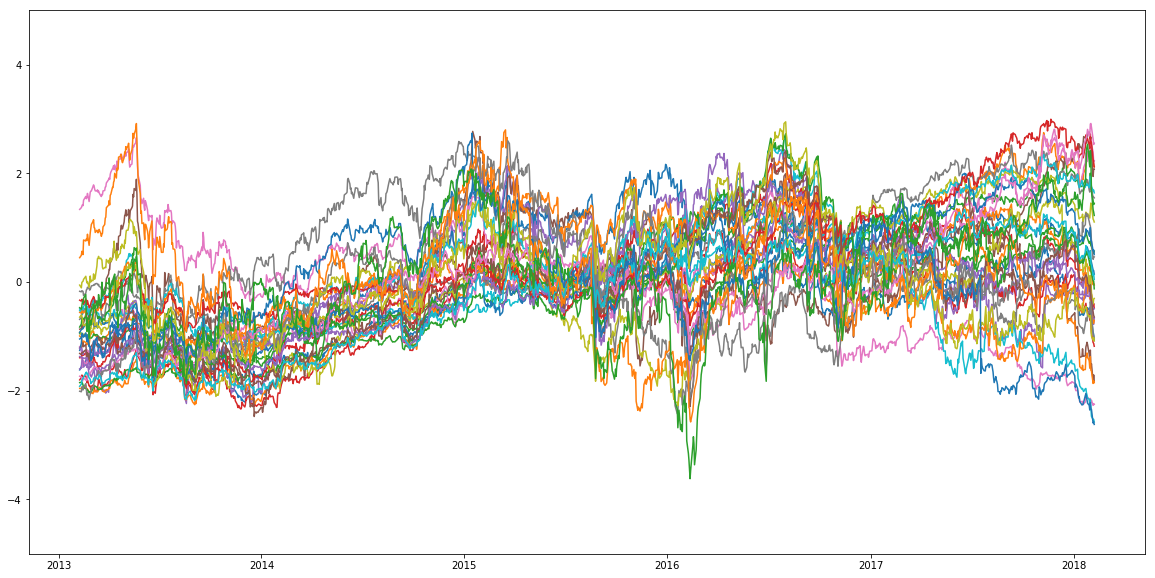

In [20]:
plt.figure(figsize=(20,10))
plt.plot(close_df1)
plt.ylim([-5,5])
plt.show()

In [21]:
close_df1.dropna(inplace=True)

In [43]:
correlations = close_df1.corr()
correlations

Name,AIV,AMT,ARE,AVB,BXP,CBG,CCI,DLR,DRE,EQIX,...,PLD,PSA,REG,SBAC,SLG,SPG,UDR,VNO,VTR,WY
Name,,,,,,,,,,,,,,,,,,,,,
AIV,1.000000,0.848734,0.930333,0.944494,0.778791,0.631965,0.858826,0.890633,0.940151,0.899427,...,0.780952,0.785995,0.849601,0.716617,0.434416,0.495472,0.950719,0.075697,0.080623,0.442002
AMT,0.848734,1.000000,0.942264,0.789301,0.542934,0.737836,0.961277,0.914687,0.926204,0.934298,...,0.944354,0.532785,0.567857,0.909852,0.221920,0.106887,0.854189,-0.211298,0.017841,0.616033
ARE,0.930333,0.942264,1.000000,0.848273,0.671252,0.745340,0.927506,0.922142,0.960135,0.940735,...,0.915895,0.596321,0.669985,0.848604,0.348057,0.241499,0.892563,-0.083465,0.057502,0.588030
AVB,0.944494,0.789301,0.848273,1.000000,0.766293,0.666228,0.808470,0.802448,0.850293,0.833502,...,0.660845,0.851748,0.829695,0.700898,0.495523,0.520335,0.978459,0.109624,-0.009120,0.383172
BXP,0.778791,0.542934,0.671252,0.766293,1.000000,0.577685,0.566488,0.516896,0.646622,0.501999,...,0.443978,0.646669,0.796868,0.540545,0.816056,0.703814,0.713141,0.565096,0.295034,0.546535
CBG,0.631965,0.737836,0.745340,0.666228,0.577685,1.000000,0.693867,0.527987,0.583094,0.619058,...,0.610592,0.359109,0.359867,0.892158,0.553277,0.084463,0.705598,0.017089,-0.109134,0.666566
CCI,0.858826,0.961277,0.927506,0.808470,0.566488,0.693867,1.000000,0.913556,0.924347,0.936686,...,0.916346,0.620260,0.659702,0.876981,0.210251,0.214761,0.874245,-0.238207,0.009517,0.523681
DLR,0.890633,0.914687,0.922142,0.802448,0.516896,0.527987,0.913556,1.000000,0.962708,0.974529,...,0.916695,0.633202,0.666363,0.704608,0.072356,0.193450,0.848422,-0.236368,0.059506,0.440360
DRE,0.940151,0.926204,0.960135,0.850293,0.646622,0.583094,0.924347,0.962708,1.000000,0.954021,...,0.920466,0.659050,0.729565,0.753578,0.261818,0.298947,0.889174,-0.091104,0.113103,0.488230


([<matplotlib.axis.YTick at 0x11d2ced68>,
 <a list of 33 Text yticklabel objects>)

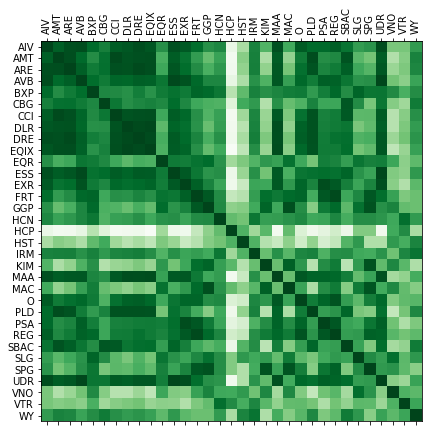

In [46]:
fig, ax = plt.subplots(figsize=(7,7))
ax.matshow(correlations, cmap=cm.get_cmap('Greens'))
plt.xticks(range(len(correlations.columns)), correlation.columns, rotation='vertical')
plt.yticks(range(len(correlations.columns)), correlation.columns)

In [26]:
Z = linkage(correlation, 'average')

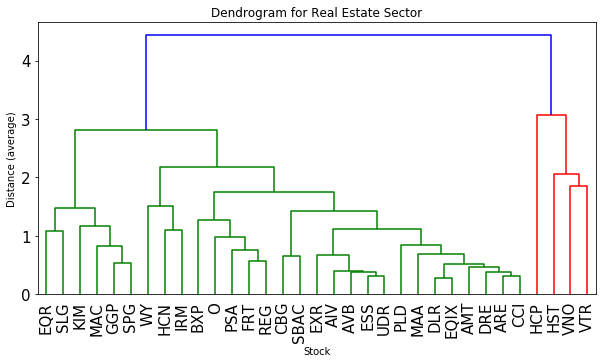

In [107]:
plt.figure(figsize=(10, 5))
plt.title('Dendrogram for Real Estate Sector')
plt.xlabel('Stock')
plt.ylabel('Distance (average)')
dendrogram(Z, labels = correlations.columns)
pylab.xticks(rotation=90, fontsize=15)
pylab.yticks(fontsize=15)
plt.show()

In [111]:
def plot_correlating_stocks(s1_high, s2_high, s1_low, s2_low):
    '''
    Takes in stock symbols that wish to be compared and plotted
    '''
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    
    ax1.plot(close_df1[s1_high])
    ax1.plot(close_df1[s2_high])
    ax1.set_title('Correlation = ' + str(correlations[s1_high][s2_high]))
    ax1.set_ylabel('Normalized Close')
    ax1.set_xlabel('Date (Years)')
    ax1.legend(loc='best')
    
    ax2.plot(close_df1[s1_low])
    ax2.plot(close_df1[s2_low])
    ax2.set_title('Correlation = ' + str(correlations[s1_low][s2_low]))
    ax2.set_ylabel('Normalized Close')
    ax2.set_xlabel('Date (Years)')
    ax2.legend(loc='best')

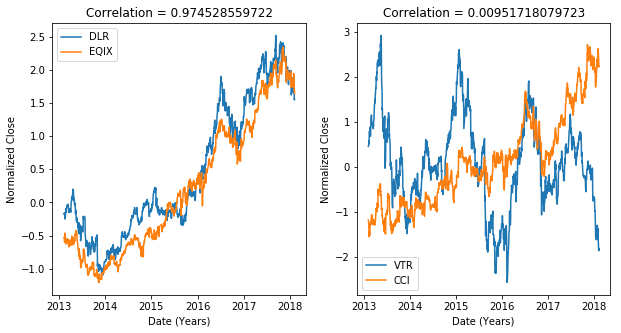

In [118]:
plot_correlating_stocks("DLR", "EQIX", "VTR", "CCI")